In [2]:
import configparser
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import subprocess
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")

import config_readwrite as crw
import fet

In [3]:
import plot_params as pp

pp.fonts()  # load font parameters
summary_labels = pp.summary_labels()  # get categorical labels for activity codes

In [4]:
name = os.path.join("/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/", "config")
config_, config_name_ = crw.read_config(name)

In [5]:
RE = config_["REPEATMASKER"]["results"]

REGIONS_X_TE = config_["REPEATMASKER"]["te_data_hg38"]
FP = config_[f"TF_FOOTPRINTING_JASPAR_GM12878"]["FP"]
REGION_ANNOT =config_["CIS_TRANS"]["regions_annotations"] ## human shared accessibility regions

ALL_ALU_OR =config_["REPEATMASKER"]["all_alu_OR"]  ## FP enrichment in all alus
CISTRANS_ALU_OR =config_["REPEATMASKER"]["cis+trans_alu_OR"]  ## FP enrichment in all alus

RNA = config_["RNASEQ"]["dif_exp"]
FPKM = config_["RNASEQ"]["GM12878_FPKM"]

# Footprinting

In [6]:
fp = pd.read_csv(FP, sep = '\t')
fp.shape

(312632, 22)

# TEs 

In [7]:
te = pd.read_csv(REGIONS_X_TE, sep = '\t')
te.head()

,#chr,start,end,region_id,te_count-hg38,te,te_fam
0,chr1,959034,959154,chr1:959034-959154,0,['.'],['-1']
1,chr1,1002089,1002179,chr1:1002089-1002179,0,['.'],['-1']
2,chr1,1064140,1064260,chr1:1064140-1064260,1,['(CCTGG)n'],['Simple_repeat']
3,chr1,1214948,1215208,chr1:1214948-1215208,1,['MLT1B'],['LTR/ERVL-MaLR']
4,chr1,1215328,1215508,chr1:1215328-1215508,0,['.'],['-1']


# add region annotations to TE

In [8]:
regions = pd.read_csv(REGION_ANNOT, sep = '\t')
te = pd.merge(te, regions, how = "left")

# get regions w/ Alus

In [9]:
target_te = "Alu"

# figure out if fp is enriched in alu region 

Test 1 - is FP enriched for Alu overlap v. all non-alu elements, all other FPs?
         
    For all regions     
                         Alu overlap      Alu no overlap
    FP overlap - TF x 
    FP overlap - not TF x 
    
    
Test 2 - is TF x enriched for cis-only + alu elements? v. all other activities overlapping and all other alu elements

    For TF x 
                        Alu overlap      Alu no overlap
    cis only 
    not cis only
    
    
    
Test 3 - per activity category, is footprint enriched in alu-overlapping elements v. non- alu elements, other TFs. 

    For cis+trans
                        Alu overlap.   No alu overlap
            TF x 
            not TF x 

are Alu regions enriched for a FP overall?

                                Region overlaps alu       region does not overlap alu
    TF footprints region - True
    TF footprints region - False

In [11]:
# sets of regions that overlap alu target
def get_TE_regions(target_te, te_df):
    te_df['target'] = False
    te_df.loc[te_df["te"].str.contains(target_te), "target"]= True


    target_true = set(te_df.loc[te_df["target"]==True, "region_id"])
    target_false = set(te_df.loc[te_df["target"]!= True, "region_id"])
    target_false = target_false.difference(target_true)  # check and remove any regions that both overlap and do not overlap alu target?
    
    return target_true, target_false

In [12]:
def get_FP_regions(tf, fp_df):
    
    """
    return set of regions that overlap/ do not overlap TF footprint
    """
    
    tf_true = set(fp_df.loc[fp_df[tf] == True, "region_id"]) # get regions w/ footprint
    tf_false = set(fp_df.loc[fp_df[tf] != True, "region_id"])  # get regions w/o FP
    tf_false = tf_false.difference(tf_true) # remove any region overlap
    
    return tf_true, tf_false

In [13]:
def FP_x_TE_OR(tf, fp_df, target_te, te_df):
    te_true, te_false = get_TE_regions(target_te, te_df)
    tf_true, tf_false = get_FP_regions(tf, fp_df)
    

    a = len(tf_true.intersection(te_true))
    b = len(tf_false.intersection(te_true))
    c = len(tf_true.intersection(te_false))
    d = len(tf_false.intersection(te_false))

    comparison = f"{target_te}_x_{tf}"
    
    results = fet.get_2x2(a,b,c,d,comparison)

    results["comparison"] = comparison
    results["tf"] = tf.split("_")[0]
    return results, comparison
   

# get all FP enrichments for ALU 

In [14]:
if os.path.exists(ALL_ALU_OR) is False:
    alu_FP_results = {}
    target_te = "Alu"
    TF_list = list(fp)[4:]
    FP_DF = fp
    TE_DF = te

    for TF in TF_list:
        comparison = f"{target_te}_x_{TF}"
        if comparison not in alu_FP_results.keys():
            results, comparison = FP_x_TE_OR(TF, FP_DF, target_te, TE_DF)
            alu_FP_results[comparison] = results
    alu_FP = fet.fdr_correction(alu_FP_results)

    alu_FP.to_csv(ALL_ALU_OR, sep = '\t', index = False)
else:
    alu_FP = pd.read_csv(ALL_ALU_OR, sep = '\t')

0 ZNF135 1.8983139167304277
1 ZNF384 1.933297648104339
2 ZNF460 1.1641654519840825
3 PITX2 2.3966530733139337
4 OTX2 1.9792049000279464
5 MEF2C 1.1628004106266918
6 FOXD3 1.3063042515083507
7 MGA 1.373838034339648
8 IRF1 0.6524568380253719
9 ESR1 1.3758287851112958
10 TGIF2 1.2873545993590814
11 PKNOX2 1.1963275354493208
12 E2F2 1.7423870785707019
13 MEF2A 0.8978265630028333
14 TBX4 1.3179723455196743
15 ZNF136 1.181891832837152
16 TGIF1 1.1601866554217108
17 STAT2 0.5857198258181063
18 PROP1 1.3582521048222491
19 NR2F6VAR.2 1.0429920073189611
20 PHOX2B 1.1251836434634641
21 TBX15 1.1079863943964454


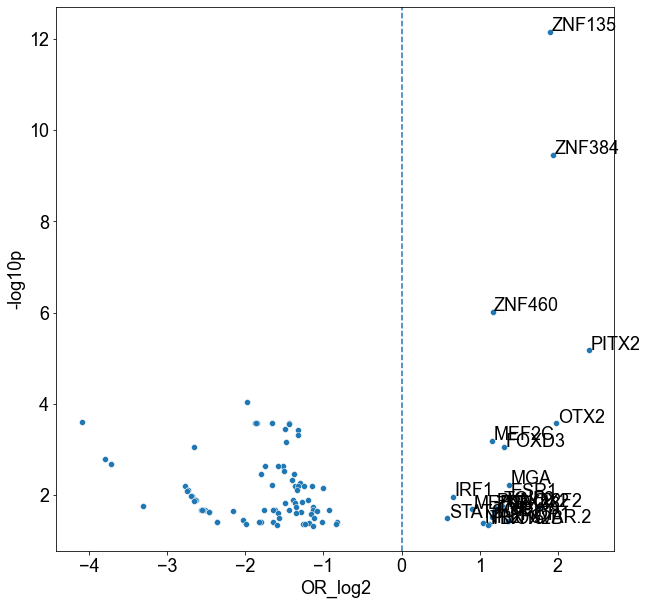

In [15]:
x = "OR_log2"
y = "-log10p"
data = alu_FP.loc[alu_FP["reject_null"]==True].sort_values(by = ["FDR_P"])
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(x=x,y=y,data=data)
sig = data.loc[(data[x].astype(float)>0) 
               & (data["reject_null"]==True)
              ]

# Annotate sign TE label points 
for i, l in enumerate(sig["tf"]):
    print(i, l, sig[x].iloc[i])
    ax.annotate(l, (sig[x].iloc[i]+0.02, sig[y].iloc[i]+0.02) )
ax.axvline(0, ls = "--")

# cis + trans only Alu FP enrichment

In [16]:
ct = ["cis+trans", "trans_only", "cis_only",
      'HH-active_MM-inactive_cis+trans', 
     "HH-active_MM-inactive_trans_only",
     "MM-active_HH-inactive_trans_only", 
     "MM-active_HH-inactive_cis+trans", ]
    
if os.path.exists(CISTRANS_ALU_OR) is False:

    target_te = "Alu"
    active_fp_te_results = {}

    for col in ct:
        active_regions = set(regions.loc[regions[col]==1, "region_id"])  # get the set of regions

        alu_FP_results = {}

        TF_list = list(fp)[4:]  # list of TFs to test. 

        FP_DF = fp.loc[fp.region_id.isin(active_regions)]  # get the FP dataframe overlapping the annotated regions 
        TE_DF = te.loc[te.region_id.isin(active_regions)]  # get the TE dataframe overlapping the annotated regions

        for TF in TF_list:  # for each transcription factor

            comparison = f"{target_te}_x_{TF}"

            if comparison not in alu_FP_results.keys():
                results, comparison = FP_x_TE_OR(TF, FP_DF, target_te, TE_DF)  # test the enrichment of the FP and TE overlap. 
                alu_FP_results[comparison] = results

        alu_FP = fet.fdr_correction(alu_FP_results)
        alu_FP['dataset'] = col

        active_fp_te_results[col] = alu_FP # add results to dictionary
    te_fp = pd.concat(active_fp_te_results.values())
    te_fp.to_csv(CISTRANS_ALU_OR, sep = '\t', index = False)
else:
    te_fp = pd.read_csv(CISTRANS_ALU_OR, sep = '\t')

In [17]:
te_fp.loc[(te_fp.dataset=="trans_only")&(te_fp.reject_null==True)]

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,tf,reject_null,FDR_P,asterisks,-log10p,dataset
2244,17,27,291,1712,3.704213,0.000096,1.993804,0.893643,6.881917,0.893643,1.889167,0.995523,2.782810,Alu_x_IRF1_MA0050.2,IRF1,True,0.023919,*,1.621255,trans_only
2546,15,29,201,1802,4.637159,0.000020,2.444748,0.923556,8.795691,0.923556,2.213241,1.289686,3.136797,Alu_x_IRF3_MA1418.1,IRF3,True,0.014614,*,1.835224,trans_only
2814,16,28,260,1743,3.830769,0.000093,2.044515,0.905876,7.177641,0.905876,1.937634,1.031758,2.843510,Alu_x_STAT2_MA1623.1,STAT2,True,0.023919,*,1.621255,trans_only




 cis+trans 


0 ZNF135 2.4635417152664827
1 ZNF460 1.7348624276333982
2 ZNF384 2.2275925893155017
3 PITX2 2.6029657354210465
4 ZKSCAN5 -2.652540610525774
5 ZBTB7A -2.2558969453863247
6 KLF15 -2.850824770783155
7 OTX2 2.129144160526801
8 FOXD3 1.5444422506969822
9 RARG 1.7020032118231398
10 ETS2 -2.7180445059442118
11 MEF2A 1.3083302090338953
12 ZNF281 -2.681849746540499


 trans_only 


0 IRF3 2.213241205115556
1 IRF1 1.889166982579734
2 STAT2 1.9376341190396265


 cis_only 




 HH-active_MM-inactive_cis+trans 


0 ZNF135 2.473728548393757
1 ZNF460 1.8190842146397117
2 ZNF384 2.2703977942472804
3 PITX2 2.8569582927086348
4 FOXD3 1.9104863187690917
5 ZKSCAN5 -3.7545389356417687
6 ZNF148 -2.871266685877797
7 ZNF281 -inf
8 MEF2C 1.5294942279187989
9 KLF15 -3.541276634750002
10 OTX2 2.389956105571777


/home/fongsl/.local/lib/python3.6/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]




 HH-active_MM-inactive_trans_only 




 MM-active_HH-inactive_trans_only 




 MM-active_HH-inactive_cis+trans 


0 ZNF135 2.4378605785244583


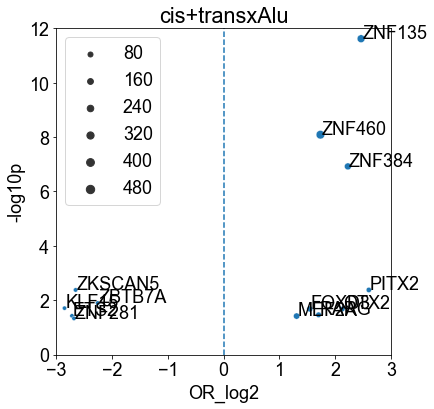

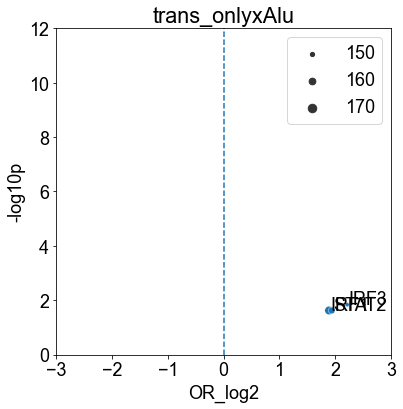

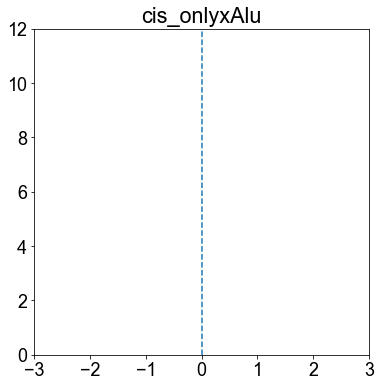

/home/fongsl/.local/lib/python3.6/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


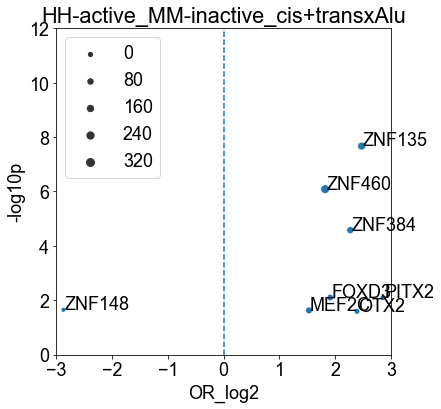

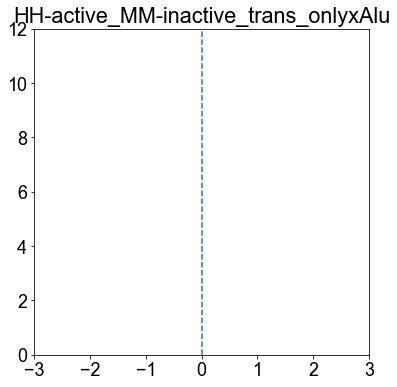

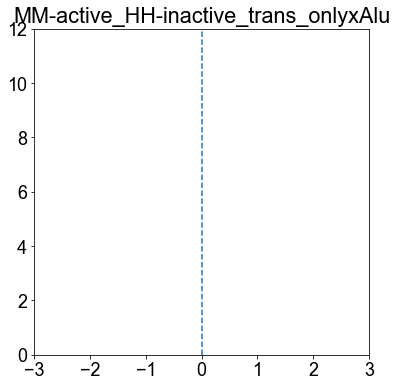

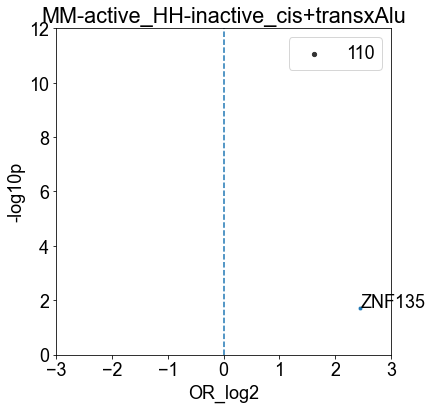

In [19]:
for col in ct:
    print("\n\n", col, "\n\n")
    x = "OR_log2"
    y = "-log10p"
    data = te_fp.loc[(te_fp["reject_null"]==True)
                     & (te_fp['dataset']==col)].sort_values(by = ["FDR_P"])
    size = list(data["a"])
    size_=(i*10 for i in size)
    
    fig, ax = plt.subplots(figsize = (6,6))
    sns.scatterplot(x=x,y=y,data=data,
                   size=size_)
    
    ax.set(title = f"{col}x{target_te}",
           xlim=(-3,3),
           ylim=(0,12)
          )
    sig = data.loc[
                    #(data[x].astype(float)>0) 
                    (data["reject_null"]==True)
                  #& data[y]>data[y].quantile(0.5)
                  ]

    # Annotate sign TE label points 
    for i, l in enumerate(sig["tf"]):
        print(i, l, sig[x].iloc[i])
    
        ax.annotate(l, (sig[x].iloc[i]+0.02, sig[y].iloc[i]+0.02) )
    ax.axvline(0, ls = "--")

    out = os.path.join(RE, f"{target_te}_FP_{col}_OR.pdf")
    plt.savefig(out, bbox_inches = "tight")

In [60]:
def add_fpkm_lo2fc(df, fpkm, rna):
    rna = rna.fillna(0)
    df = pd.merge(fpkm[["hgnc_symbol","FPKM_mean", "FPKM_Rep1", "FPKM_Rep2","ensembl_gene_id"]],df,
             right_on = "tf", left_on="hgnc_symbol" )

    df = pd.merge(rna[["SYMBOL","log2FoldChange","padj", "ENSEMBL"]],df,
             right_on = "ensembl_gene_id", left_on="ENSEMBL" ).drop_duplicates()
    
   
    
    df = df.sort_values(by = "FPKM_mean", ascending = False).drop_duplicates()
    df["log2FoldChange"] = df['log2FoldChange']*-1 # reverse the log2foldchange (originally log2(rhesus/human), flip direction to reflect log2(human/rhesus))
    return df 

fpkm = pd.read_csv(FPKM, sep = '\t')
rna = pd.read_csv(RNA, sep = '\t')

In [76]:
fp = add_fpkm_lo2fc(te_fp, fpkm, rna)
fp.drop_duplicates()

,SYMBOL,log2FoldChange,padj,ENSEMBL,hgnc_symbol,FPKM_mean,FPKM_Rep1,FPKM_Rep2,ensembl_gene_id,a,...,OR_log2,ci_lower_log2,ci_upper_log2,comparison,tf,reject_null,FDR_P,asterisks,-log10p,dataset
1506,IRF4,2.036708,1.165605e-178,ENSG00000137265,IRF4,295.012225,312.319976,277.704475,ENSG00000137265,2,...,-0.151044,-2.195708,1.893621,Alu_x_IRF4_MA1419.1,IRF4,False,1.000000,NaN,-0.000000,MM-active_HH-inactive_cis+trans
1505,IRF4,2.036708,1.165605e-178,ENSG00000137265,IRF4,295.012225,312.319976,277.704475,ENSG00000137265,10,...,0.101780,-0.822914,1.026475,Alu_x_IRF4_MA1419.1,IRF4,False,1.000000,NaN,-0.000000,cis+trans
1509,IRF4,2.036708,1.165605e-178,ENSG00000137265,IRF4,295.012225,312.319976,277.704475,ENSG00000137265,1,...,-0.727724,-3.606182,2.150734,Alu_x_IRF4_MA1419.1,IRF4,False,1.000000,NaN,-0.000000,cis_only
1508,IRF4,2.036708,1.165605e-178,ENSG00000137265,IRF4,295.012225,312.319976,277.704475,ENSG00000137265,9,...,1.987189,0.897869,3.076509,Alu_x_IRF4_MA1419.1,IRF4,False,0.106053,NaN,0.974478,trans_only
1507,IRF4,2.036708,1.165605e-178,ENSG00000137265,IRF4,295.012225,312.319976,277.704475,ENSG00000137265,8,...,0.147720,-0.893844,1.189284,Alu_x_IRF4_MA1419.1,IRF4,False,1.000000,NaN,-0.000000,HH-active_MM-inactive_cis+trans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,HOXA5,-0.000000,0.000000e+00,ENSG00000106004,HOXA5,0.000000,0.000000,0.000000,ENSG00000106004,0,...,-inf,-3.819976,4.335635,Alu_x_HOXA5_MA0158.2,HOXA5,False,1.000000,NaN,-0.000000,cis_only
858,HOXA5,-0.000000,0.000000e+00,ENSG00000106004,HOXA5,0.000000,0.000000,0.000000,ENSG00000106004,1,...,1.623947,-1.328762,4.576656,Alu_x_HOXA5_MA0158.2,HOXA5,False,1.000000,NaN,-0.000000,trans_only
857,HOXA5,-0.000000,0.000000e+00,ENSG00000106004,HOXA5,0.000000,0.000000,0.000000,ENSG00000106004,1,...,-0.193165,-3.076174,2.689844,Alu_x_HOXA5_MA0158.2,HOXA5,False,1.000000,NaN,-0.000000,HH-active_MM-inactive_cis+trans
856,HOXA5,-0.000000,0.000000e+00,ENSG00000106004,HOXA5,0.000000,0.000000,0.000000,ENSG00000106004,0,...,-inf,-4.027882,4.134247,Alu_x_HOXA5_MA0158.2,HOXA5,False,1.000000,NaN,-0.000000,MM-active_HH-inactive_cis+trans


In [78]:
target_fps

['FOXD3', 'MEF2A', 'ZNF460', 'ZNF384', 'PITX2', 'OTX2', 'RARG', 'ZNF135']

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


ZNF460 (-0.07060668961359204, 35.158474656200774)
MEF2A (-0.6815294386658672, 28.487197315586123)
RARG (-0.2803737315282288, 0.62953013210599)
PITX2 (0.43229594521410153, 0.04753903325692162)
FOXD3 (0.02, 0.02)


/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


STAT2 (0.04246570406571047, 13.478671088874187)
IRF3 (-1.0674064477138712, 6.345059432582593)


/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


ZNF460 (-0.07060668961359204, 35.158474656200774)
PITX2 (0.43229594521410153, 0.04753903325692162)
FOXD3 (0.02, 0.02)


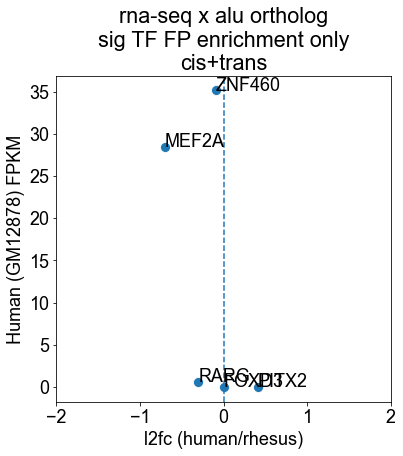

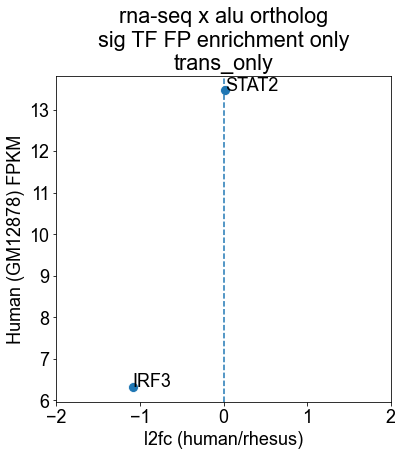

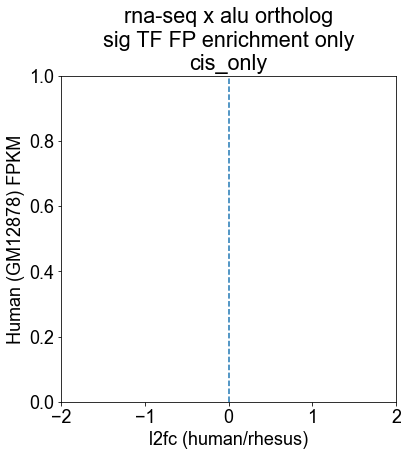

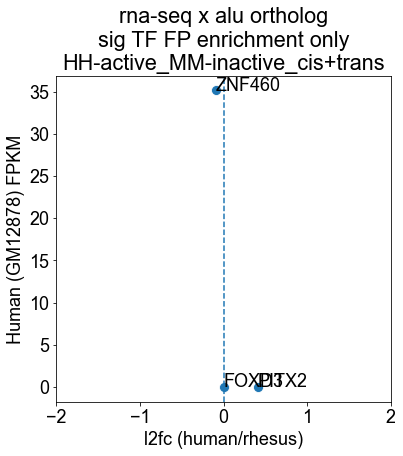

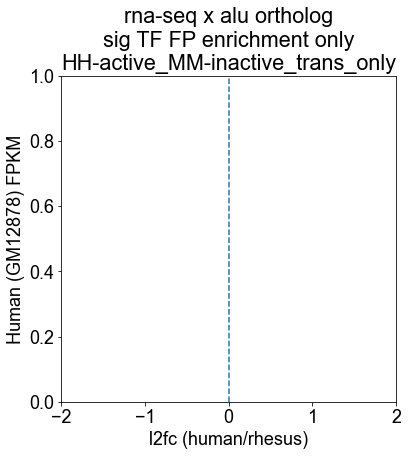

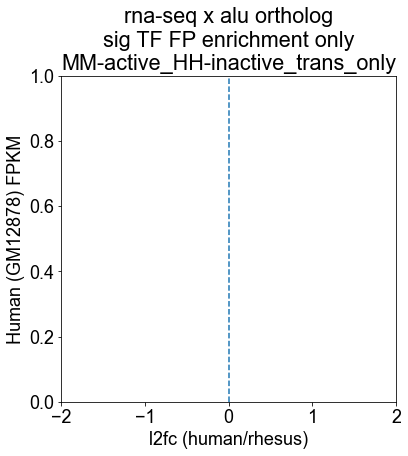

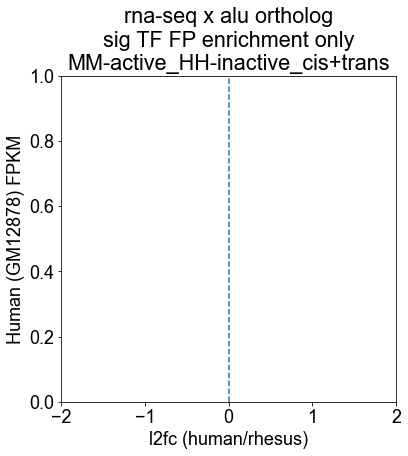

In [91]:
for name in ct:
    target_fps = fp.loc[
                        (fp["reject_null"]==True)&
                        (fp["dataset"]==name) 
                        &(fp["OR_log2"]>0)
                        ]
    x = "log2FoldChange"
    y="FPKM_mean"
    data = target_fps

    hue="OR_log2"
    target_fps[hue] = target_fps[hue].round(1)
    fig, ax = plt.subplots(figsize = (6,6))
    
    sns.scatterplot(x=x, y=y, data=data, 
                    #hue=hue,
                    s =100
                   )
    
    for i, l in enumerate(data["SYMBOL"]):
        print(l, (data[x].iloc[i]+0.02, data[y].iloc[i]+0.02) )
        ax.annotate(l, (data[x].iloc[i], data[y].iloc[i]) )
    ax.axvline(0, ls = "--")
    ax.set(title = f"rna-seq x alu ortholog\nsig TF FP enrichment only\n{name}",
          xlabel = "l2fc (human/rhesus)",
           ylabel = "Human (GM12878) FPKM",
           xlim =(-2,2)
          )
    out = os.path.join(RE, f"DE_x_FPKM_RNAseq_alu_TF_{name}.pdf")
    plt.savefig(out, bbox_inches = "tight")